In [266]:
import pandas as pd

pd.options.mode.copy_on_write = True

In [267]:
df = pd.read_csv('csv/house_price_raw.csv')
df.columns = ['PriceTitle', 'Location', 'Size', 'Agent', 'Link', 'Desc']
df = df.drop_duplicates(subset=['PriceTitle', 'Location', 'Size', 'Link'])
df.describe()

,PriceTitle,Location,Size,Agent,Link,Desc
count,21939,21939,21611,18590,21939,21939
unique,2102,168,2527,381,21938,19678
top,Rp 8 Juta /m²,"Dago, Bandung",1000 m²,Pakar Mulia Property logo,/properti/bandung/las4006765/,Tanah Komersial Cocok Untuk Perdagangan Dan Lo...
freq,551,1425,264,1680,2,28


In [268]:
def to_numeric_term(s: str):
    s = s.lower()
    if s == 'miliar': return 1e9
    if s == 'juta': return 1e6
    if s == 'ribu': return 1e3

def assign_price_per_m2(df_inp: pd.DataFrame):
    # separate per meter2 price and total price
    str_m2 = 'Rp (.*?) /m²'
    str_total = 'Rp (.*?) Total'
    df = df_inp['PriceTitle'].str.extract(f'{str_m2}|{str_total}')
    df.columns = ['price_per_m2_raw', 'price_total_raw']
    df = df.assign(total_size=df_inp['Size'], price_per_m2=[0.0 for _ in range(len(df))])

    # convert per meter2 price to numeric
    pm2 = df['price_per_m2_raw']
    pm2_f : pd.Series = pm2[pm2.notnull()]
    pm2_f = pm2_f.str.extract('(.*?) ([a-zA-Z]*)')
    pm2_f.columns = ["pt1", "pt2"]
    pm2_f["pt1"] = pm2_f["pt1"].str.replace(',','.').astype(float)
    pm2_f["pt2"] = pm2_f["pt2"].apply(to_numeric_term)
    pm2_f = pm2_f["pt1"] * pm2_f["pt2"]
    df.loc[pm2.notnull(), 'price_per_m2'] = pm2_f

    # convert total price to numeric then divide by total land size
    ptotal = df['price_total_raw']
    size = df_inp[ptotal.notnull()]['Size'].str.extract('(.*?) m²')
    size = size[0].apply(float)
    ptotal_f : pd.Series = ptotal[ptotal.notnull()]
    ptotal_f = ptotal_f.str.extract('(.*?) ([a-zA-Z]*)')
    ptotal_f.columns = ["pt1", "pt2"]
    ptotal_f["pt1"] = ptotal_f["pt1"].str.replace(',','.').astype(float)
    ptotal_f["pt2"] = ptotal_f["pt2"].apply(to_numeric_term)
    ptotal_f = ptotal_f["pt1"] * ptotal_f["pt2"] / size
    df.loc[ptotal.notnull(), 'price_per_m2'] = ptotal_f

    # filter NaN
    df.dropna(subset=['price_per_m2'], inplace=True)

    temp = df_inp[df_inp.index.isin(df.index)]
    df = temp.assign(price_per_m2=df['price_per_m2'])
    return df

df = assign_price_per_m2(df)

In [294]:
# try to normalize data distribution (mean-2*std <= min && max <= mean+2*std)
# top = int(0.80059 * len(df))
# top = int(0.9795 * len(df))
top = int(0.97 * len(df))
bot = int(0 * len(df))
df = df[df['price_per_m2'] >= 5e4]

df_sorted = df.sort_values(by="price_per_m2", ascending=True)
df_filtered = df_sorted.iloc[bot:top].reset_index(drop=True)
df_filtered = df_filtered[df_filtered['Link'] != '/properti/bandung/las2647328/']
df_filtered = df_filtered[~df_filtered['Location'].str.contains('Cimahi')]
df_filtered.describe(include='all')

,PriceTitle,Location,Size,Agent,Link,Desc,price_per_m2
count,20564,20564,20375,17353,20564,20564,2.056400e+04
unique,1699,166,2436,363,20563,18490,NaN
top,Rp 8 Juta /m²,"Dago, Bandung",1000 m²,Pakar Mulia Property logo,/properti/bandung/las4006765/,Tanah Komersial Cocok Untuk Perdagangan Dan Lo...,NaN
freq,546,1315,255,1618,2,27,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,7.802143e+06
std,NaN,NaN,NaN,NaN,NaN,NaN,5.668557e+06
min,NaN,NaN,NaN,NaN,NaN,NaN,5.000000e+04
25%,NaN,NaN,NaN,NaN,NaN,NaN,3.500000e+06
50%,NaN,NaN,NaN,NaN,NaN,NaN,6.800000e+06
75%,NaN,NaN,NaN,NaN,NaN,NaN,1.100000e+07


In [295]:
price_per_m2 = df_filtered['price_per_m2']
mean, min_, max_, std = price_per_m2.mean(), price_per_m2.min(), price_per_m2.max(), price_per_m2.std()
print((min_ - (mean-2*std))/1e6)
print(((mean+2*std) - max_)/1e6)

3.584970534230873
-15.860743048483808


In [296]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

/tmp/ipykernel_1492/4043330655.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar.set_xticklabels(bar.get_xticklabels(), rotation=45)


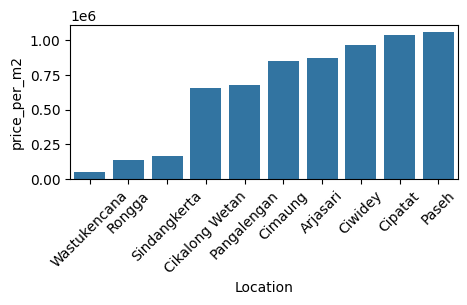

In [297]:
d = df_filtered.groupby('Location')['price_per_m2'].mean().to_frame().reset_index()
d['Location'] = d['Location'].str.replace(r', Bandung', '', regex=True)
d = d.sort_values('price_per_m2')
_, ax = plt.subplots(figsize=(5,2))
bar = sns.barplot(ax=ax, data=d.iloc[:10], x='Location', y='price_per_m2')
bar.set_xticklabels(bar.get_xticklabels(), rotation=45)
plt.show()

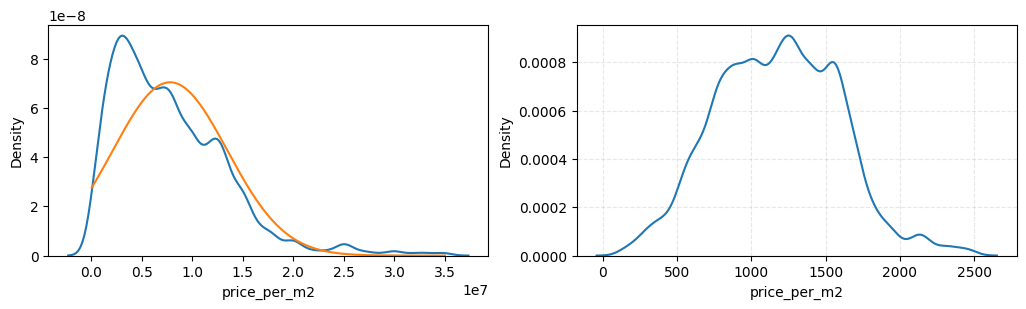

In [302]:
pdf = norm.pdf(df_filtered['price_per_m2'].sort_values(), mean, std)

_, axes = plt.subplots(1,2, figsize=(12.5,3))
sns.kdeplot(ax=axes[0], data=df_filtered['price_per_m2'].sort_values())
axes[0].plot(df_filtered['price_per_m2'].sort_values(), pdf)
dnorm = df_filtered['price_per_m2']**0.45
sns.kdeplot(ax=axes[1], data=dnorm)

plt.xlabel("price_per_m2")
plt.ylabel("Density")
plt.grid(True, alpha=0.3, linestyle="--")
plt.show()